In [1]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

/home/ieyuhaoliu/anaconda3/envs/brevitas/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ieyuhaoliu/anaconda3/envs/brevitas/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_train = torchvision.datasets.MNIST('./data/', 
                                        train=True, download=True,
                                        transform=torchvision.transforms.Compose
                                        ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                        ]))
data_test = torchvision.datasets.MNIST('./data/', 
                                       train=False, download=True,
                                       transform=torchvision.transforms.Compose
                                       ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                       ]))

In [3]:
import torch

batch_size_train = 64
batch_size_test = 1000

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size=batch_size_train, 
                                                shuffle=True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size=batch_size_test, 
                                               shuffle=True)

In [4]:
examples = enumerate(data_loader_train)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data[0][0])
example_data[0][0].shape

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

torch.Size([28, 28])

/tmp/ipykernel_28033/1766397098.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


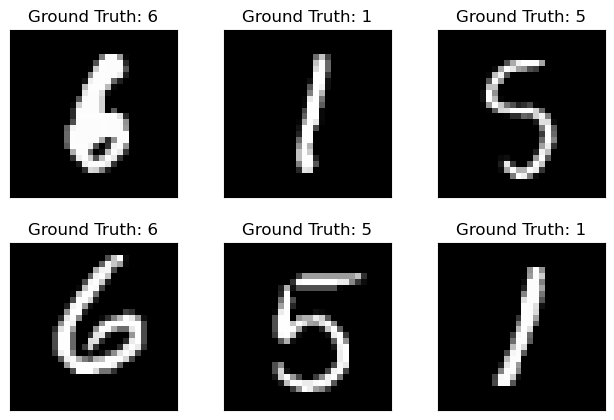

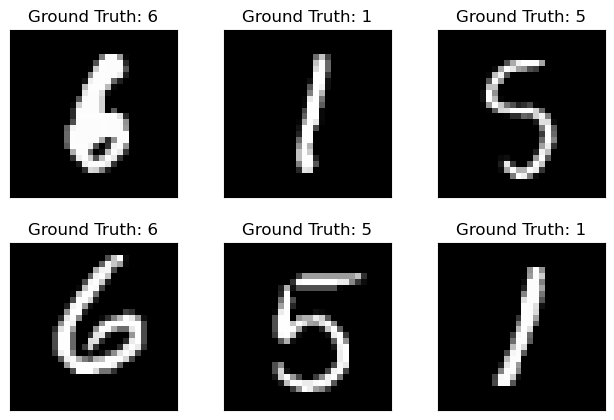

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
input_size = 1*28*28      
hidden1 = 64      
hidden2 = 64
hidden3 = 64
weight_bit_width = 4
act_bit_width = 4
num_classes = 10  

In [7]:
import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU
import torch.nn as nn
from torch.nn import Module
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Setting seeds for reproducibility
torch.manual_seed(0)

class TFC_W4A4(Module):
    def __init__(self):
        super(TFC_W4A4, self).__init__()
        
        self.input = qnn.QuantIdentity(
                         quant_type='int',
                         scaling_impl_type='const',
                         bit_width=act_bit_width,
                         min_val=-8.0,
                         max_val=7.0, 
                         return_quant_tensor=True
                     )
        
        self.fc1   = qnn.QuantLinear(
                         input_size, 
                         hidden1, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn1   = nn.BatchNorm1d(hidden1)
        self.sigmoid1 = qnn.QuantSigmoid(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.fc2   = qnn.QuantLinear(
                         hidden1, 
                         hidden2, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        self.bn2   = nn.BatchNorm1d(hidden2)
        self.sigmoid2 = qnn.QuantSigmoid(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        
        self.fc3   = qnn.QuantLinear(
                         hidden2, 
                         hidden3, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        self.bn3   = nn.BatchNorm1d(hidden3)
        self.sigmoid3 = qnn.QuantSigmoid(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        
        self.out   = qnn.QuantLinear(
                         hidden3, 
                         num_classes, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.accu_min_1 = 65535.0
        self.accu_max_1 = 0.0
        
        self.out_min_1 = 65535.0
        self.out_max_1 = 0.0
        
        self.accu_min_2 = 65535.0
        self.accu_max_2 = 0.0
        
        self.out_min_2 = 65535.0
        self.out_max_2 = 0.0
        
        self.accu_min_3 = 65535.0
        self.accu_max_3 = 0.0
        
        self.out_min_3 = 65535.0
        self.out_max_3 = 0.0

    def forward(self, x, en):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        
        #out = self.relu1(self.bn1(self.fc1(out)))
        out=self.fc1(out)
        if (en==True):
            if (out.max()>self.accu_max_1):
                self.accu_max_1 = out.max()
            if (out.min()<self.accu_min_1):
                self.accu_min_1 = out.min()
        out=self.sigmoid1(self.bn1(out))
        if (en==True):
            if (out.value.max()>self.out_max_1):
                self.out_max_1 = out.value.max()
            if (out.value.min()<self.out_min_1):
                self.out_min_1 = out.value.min()
                
        #out = self.relu2(self.bn2(self.fc2(out)))
        out=self.fc2(out)
        if (en==True):
            if (out.max()>self.accu_max_2):
                self.accu_max_2 = out.max()
            if (out.min()<self.accu_min_2):
                self.accu_min_2 = out.min()
        out=self.sigmoid2(self.bn2(out))
        if (en==True):
            if (out.value.max()>self.out_max_2):
                self.out_max_2 = out.value.max()
            if (out.value.min()<self.out_min_2):
                self.out_min_2 = out.value.min()
                
        #out = self.relu3(self.bn3(self.fc3(out)))
        out=self.fc3(out)
        if (en==True):
            if (out.max()>self.accu_max_3):
                self.accu_max_3 = out.max()
            if (out.min()<self.accu_min_3):
                self.accu_min_3 = out.min()
        out=self.sigmoid3(self.bn3(out))
        if (en==True):
            if (out.value.max()>self.out_max_3):
                self.out_max_3 = out.value.max()
            if (out.value.min()<self.out_min_3):
                self.out_min_3 = out.value.min()
                
        out = self.out(out)
        
        return out
   
model = TFC_W4A4()

In [8]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        #inputs, target = inputs.cuda(), target.cuda()
        inputs, target = Variable(inputs), Variable(target)
        
        outputs = model(inputs, False)
        _,pred = torch.max(outputs.data,1)
        
        optimizer.zero_grad()
        loss = criterion(outputs,target)
 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.numpy()) 
           
    return losses

In [9]:
import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader, enable=False):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            #inputs, target = inputs.cuda(), target.cuda()
            inputs, target = Variable(inputs),Variable(target)
            output = model(inputs, enable)
            _,pred = torch.max(output,1)
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [10]:
num_epochs = 10
learn_rate = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [11]:
# loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, betas=(0.9, 0.999))

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

Training loss = 0.040986 test accuracy = 0.970300: 100%|█| 10/10 [03:37<00:00, 2


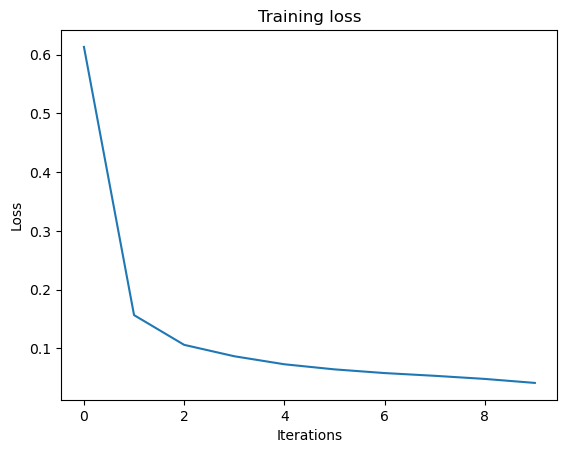

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

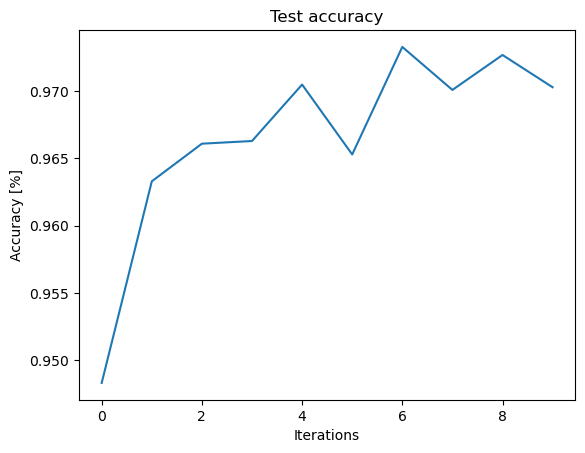

In [14]:
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [15]:
test(model, data_loader_test, True)

0.9703

In [16]:
test_1_in = torch.from_numpy(np.ones((1000,64)).astype('f'))
test_1_out = model.sigmoid1(model.bn1(test_1_in))
scale_1 = test_1_out.scale.cpu().detach().numpy()
zero_point_1 = test_1_out.zero_point.cpu().detach().numpy()

test_2_in = torch.from_numpy(np.ones((1000,64)).astype('f'))
test_2_out = model.sigmoid2(model.bn2(test_2_in))
scale_2 = test_2_out.scale.cpu().detach().numpy()
zero_point_2 = test_2_out.zero_point.cpu().detach().numpy()

test_3_in = torch.from_numpy(np.ones((1000,64)).astype('f'))
test_3_out = model.sigmoid3(model.bn3(test_3_in))
scale_3 = test_3_out.scale.cpu().detach().numpy()
zero_point_3 = test_3_out.zero_point.cpu().detach().numpy()

In [17]:
print("Layer 1:\n")
print("    Accumulator Output Range: [", model.accu_min_1, ", ", model.accu_max_1, "]\n")
print("    Multi-Threshold Output Range: [", model.out_min_1/scale_1+zero_point_1, ", ", model.out_max_1/scale_1+zero_point_1, "]\n")
print("    Scale factor: ", "%.4f" %(((model.out_max_1-model.out_min_1)/scale_1+zero_point_1)/(model.accu_max_1-model.accu_min_1)))

print("Layer 2:\n")
print("    Accumulator Output Range: [", model.accu_min_2, ", ", model.accu_max_2, "]\n")
print("    Multi-Threshold Output Range: [", model.out_min_2/scale_2+zero_point_2, ", ", model.out_max_2/scale_2+zero_point_2, "]\n")
print("    Scale factor: ", "%.4f" %(((model.out_max_2-model.out_min_2)/scale_2+zero_point_2)/(model.accu_max_2-model.accu_min_2)))

print("Layer 3:\n")
print("    Accumulator Output Range: [", model.accu_min_3, ", ", model.accu_max_3, "]\n")
print("    Multi-Threshold Output Range: [", model.out_min_3/scale_3+zero_point_3, ", ", model.out_max_3/scale_3+zero_point_3, "]\n")
print("    Scale factor: ", "%.4f" %(((model.out_max_3-model.out_min_3)/scale_3+zero_point_3)/(model.accu_max_3-model.accu_min_3)))

Layer 1:

    Accumulator Output Range: [ tensor(-28.8461) ,  tensor(34.1862) ]

    Multi-Threshold Output Range: [ tensor(0.) ,  tensor(15.) ]

    Scale factor:  0.2380
Layer 2:

    Accumulator Output Range: [ tensor(-1.4195) ,  tensor(1.4068) ]

    Multi-Threshold Output Range: [ tensor(0.) ,  tensor(15.) ]

    Scale factor:  5.3073
Layer 3:

    Accumulator Output Range: [ tensor(-1.5084) ,  tensor(1.6827) ]

    Multi-Threshold Output Range: [ tensor(0.) ,  tensor(15.) ]

    Scale factor:  4.7006
